# Определение перспективного тарифа для телеком-компании

В нашем распоряжении есть данные о поведении клиентов телеком-компании, использующих два тарифа - "Смарт" и "Ультра", за несколько месяцев.
Цель исследования - определить, какой из двух тарифов приносит компании больше денег, чтобы скорректрировать рекламный бюджет и продвигать полее прибыльный продукт.

Описание тарифов:

Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

## Обзор и подготовка данных

In [70]:
# Импортируем библиотеки
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

In [71]:
try:
    calls_df = pd.read_csv('/datasets/calls.csv') #создаём датафрейм со звонками (с сервера)
    internet_df = pd.read_csv('/datasets/internet.csv') #создаём датафрейм  с интернет-трафиком(с сервера)
    messages_df = pd.read_csv('/datasets/messages.csv') #создаём датафрейм с данными о сообщениях (с сервера)
    tariffs_df = pd.read_csv('/datasets/tariffs.csv') #создаём датафрейм с тарифами (с сервера)
    users_df = pd.read_csv('/datasets/users.csv') #создаём датафрейм с данными о пользователях (с сервера)
except:
    calls_df = pd.read_csv('calls.csv') #создаём датафрейм (с компьютера)
    internet_df = pd.read_csv('internet.csv') #создаём датафрейм с интернет-трафиком(с компьютера)
    messages_df = pd.read_csv('messages.csv') #создаём датафрейм с данными о сообщениях (с компьютера)
    tariffs_df = pd.read_csv('tariffs.csv') #создаём датафрейм с тарифами (с компьютера)
    users_df = pd.read_csv('users.csv') #создаём датафрейм с данными о пользователях (с компьютера)

Запишем информацию о тарифах - стоимость пакета, количество минут, смс, гигабайтов, цену минут, смс, гигабайтов сверх пакета:

In [72]:
# заносим информацию об обоих тарифах в переменные, чтобы использовать для расчётов в дальнейшем
smart_minutes = 500
smart_messages = 50
smart_gbs = 15
smart_minutes_price = 3
smart_messages_price = 3
smart_gbs_price = 200
smart_payment = 550

ultra_minutes = 3000
ultra_messages = 1000
ultra_gbs = 30
ultra_minutes_price = 1
ultra_messages_price = 1
ultra_gbs_price = 150
ultra_payment = 1950

Теперь по порядку будем смотреть каждый датафрейм, приводить столбцы к правильным типам, по возможности исправлять ошибки и заполнять пропуски. 
Датафрейм со звонками:

In [73]:
calls_df.head(10) # вывод первых 10 строк calls_df

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [74]:
calls_df.info() # вывод информации о calls_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Сейчас столбец call_date имеет формат object, переведём его в формат datetime:

In [75]:
# переводим дату в стандартный формат
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format='%Y-%m-%d') 

In [76]:
calls_df.info() # вывод информации о calls_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Поскольку оператор всегда округляет длительность до минут, причём всегда в большую сторону, сделаем так же:

In [77]:
calls_df['duration'] = np.ceil(calls_df['duration']) # округляем значения столбца duration в большую сторону
calls_df.head() # вывод первых 5 строк calls_df

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


In [78]:
calls_df.duplicated().sum() # смотрим число дубликатов

0

Теперь проверим на адекватность значения в столбце duration, чтобы не было отрицательных и запредельно больших значений. Для этого просто посмотрим значения максимума и минимума в столбце:

In [79]:
calls_df['duration'].max() # находим максимальное значение в столбце duration

38.0

In [80]:
calls_df['duration'].min() # находим минимальное значение в столбце duration

0.0

Всё более чем адекватно, 38 минут - совсем не много. А длительность 0 у пропущенных вызовов.

Теперь займёмся датафреймом с интернет-трафиком:

In [81]:
internet_df.head(10) # вывод первых 10 строк internet_df

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [82]:
internet_df.info() # вывод информации о internet_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [83]:
internet_df.duplicated().sum() # смотрим число дубликатов

0

In [84]:
# переводим дату в стандартный формат
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format='%Y-%m-%d') 

In [85]:
internet_df['mb_used'].max() # находим максимальное значение в столбце mb_used

1724.83

In [86]:
internet_df['mb_used'].min() # находим минимальное значение в столбце mb_used

0.0

Нулевой объём трафика не кажется правдоподобным, возможно, человек зашёл в интернет и тут же вышел. Посмотрим на срез датафрейма с нулевым трафиком:

In [87]:
internet_df[internet_df['mb_used'] == 0] # смотрим срез датафрейма internet_df с нулевым трафиком 

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


Никакой системы в этом срезе не видно, таких строк около 20 000 в примерно 150-тысячном датафрейме. Думаю, их правильно будет удалить, кроме трафика и даты сессии, датафрейм не несёт никакой информации:

In [88]:
internet_df = internet_df[internet_df['mb_used'] != 0] # перезаписываем датафрейм, оставляя только строки с ненулевым трафиком

Посмотрим, что в датафрейме с сообщениями: 

In [89]:
messages_df.head(10) # вывод первых 10 строк messages_df

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [90]:
messages_df.info() # вывод информации о messages_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [91]:
messages_df.duplicated().sum() # Смотрим число дубликатов

0

In [92]:
# переводим дату в стандартный формат
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format='%Y-%m-%d') 

Посмотрим, что в датафрейме с тарифами:

In [93]:
tariffs_df.head() # вывод первых строк tariffs_df

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [94]:
tariffs_df.info() # вывод первых информации о tariffs_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Всё ясно!
Наконец, посмотрим на датафрейм с пользователями:

In [95]:
users_df.head(10) # вывод первых 10 строк users_df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [96]:
users_df.info() # вывод информации о users_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [97]:
users_df.duplicated().sum() # Смотрим число дубликатов
# Создаём новый датафрейм с информацией о пользователях, где оставляем только id, город и тариф
users_df_new = users_df[['user_id', 'city', 'tariff']] 

In [98]:
# переводим даты в стандартный формат
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format='%Y-%m-%d') 
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], format='%Y-%m-%d') 

In [99]:
users_df.info() # вывод информации о users_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Проверим на адекватность значений столбец age: 

In [100]:
users_df['age'].min() # находим минимальное значение в столбце age

18

In [101]:
users_df['age'].max() # находим максимальное значение в столбце age

75

In [102]:
users_df['tariff'].unique() # смотрим уникальные значение в столбце tariff

array(['ultra', 'smart'], dtype=object)

В столбце tariff аномалий не обнаружено.

In [103]:
calls_df['month'] = calls_df['call_date'].dt.month # содаём столбец с месяцем звонка
messages_df['month'] = messages_df['message_date'].dt.month # содаём столбец с месяцем отправки сообщения
internet_df['month'] = internet_df['session_date'].dt.month # содаём столбец с месяцем интернет-сессии

In [104]:
# создаём сводную таблицу с числом и общей длительностью звонков за каждый месяц по каждому пользователю
calls_pivot = calls_df.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count']).reset_index()
calls_pivot.columns = ['user_id', 'month', 'duration', 'calls_number']
# создаём сводную таблицу с числом сообщений за каждый месяц по каждому пользователю
messages_pivot = messages_df.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count').reset_index()
messages_pivot.columns = ['user_id', 'month', 'messages_number']
# создаём сводную таблицу объёмом интернет-трафика за каждый месяц по каждому пользователю
internet_pivot = internet_df.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
# создаём сборный датафрейм, соединяя три сводные таблицы
df = calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
df = df.merge(internet_pivot, on=['user_id', 'month'], how='outer')
# выводим первые 10 строк датафрейма
df.head(10)

,user_id,month,duration,calls_number,messages_number,mb_used
0,1000,5,159.0,22.0,22.0,2253.49
1,1000,6,172.0,43.0,60.0,23233.77
2,1000,7,340.0,47.0,75.0,14003.64
3,1000,8,408.0,52.0,81.0,14055.93
4,1000,9,466.0,58.0,57.0,14568.91
5,1000,10,350.0,57.0,73.0,14702.49
6,1000,11,338.0,43.0,58.0,14756.47
7,1000,12,333.0,46.0,70.0,9817.61
8,1001,11,430.0,59.0,NaN,18429.34
9,1001,12,414.0,63.0,NaN,14036.66


In [105]:
# заполняем пропуски в колонках нового датафрейма нулями
df['mb_used'] = df['mb_used'].fillna(0)
df['duration'] = df['duration'].fillna(0)
df['calls_number'] = df['calls_number'].fillna(0)
df['messages_number'] = df['messages_number'].fillna(0)
# создаём колонку с объёмом трафика в гигабайтах
df['gb_used'] = df['mb_used']/1024
# округляем значения в этой колонке в большую сторону
df['gb_used'] = np.ceil(df['gb_used'])

In [106]:
# соединяем наш сводный датафрейм с таблицей, содержащей основную информацию о пользователях
df = df.merge(users_df_new, on='user_id', how='inner')
# выводим первые 5 строк нового датафрейма
df.head()

,user_id,month,duration,calls_number,messages_number,mb_used,gb_used,city,tariff
0,1000,5,159.0,22.0,22.0,2253.49,3.0,Краснодар,ultra
1,1000,6,172.0,43.0,60.0,23233.77,23.0,Краснодар,ultra
2,1000,7,340.0,47.0,75.0,14003.64,14.0,Краснодар,ultra
3,1000,8,408.0,52.0,81.0,14055.93,14.0,Краснодар,ultra
4,1000,9,466.0,58.0,57.0,14568.91,15.0,Краснодар,ultra


In [107]:
# Комментарий ревьюера
df.user_id.unique().shape 

(498,)

Посмотрим, куда могли деться два пользователя. Посмотрим, сколько их было вначале в каждой из исходных таблиц:

In [108]:
# находим число уникальных пользователей в каждой из исходных таблиц
display(len(calls_df['user_id'].unique())) 
display(len(messages_df['user_id'].unique()))
display(len(internet_df['user_id'].unique()))
display(len(users_df_new['user_id'].unique()))

492

426

497

500

В итоговый df попало 498, а в исходных было от 426 до 500. Так как таблицу с информацией о пользователях user_df_new с 500  user_id мы присоединили с how='inner', в итоговый датафрейм не попали те пользователи, которых не было ни в таблице со звонками, ни в таблице с смс, ни с интернет-трафиком. Вносили ли они плату за услуги связи - вопрос. Я предположила бы, что люди подключили тарифы, но не платили и не пользовались услугами связи и не стала бы включать этих пользователей в итоговый датафрейм

По получившейся таблице df уже можем рассчитать, сколько каждый человек отдвал оператору каждый месяц. Для этого сделаем два среза для каждого тарифа:

In [109]:
# делаем срез с тарифом smart
df_smart = df.query('tariff=="smart"')
# делаем срез с тарифом ultra 
df_ultra = df.query('tariff=="ultra"')

Для расчёта месячных платежей создаём колонки over_duration, over_messages, over_traffic для обоих тарифов, где считаем, сколько пользователи расходовали минут разговора, сообщений и трафика сверх пакета.

In [110]:
import warnings
warnings.filterwarnings('ignore')

# считаем количество минут сверх пакета 
df_smart['over_duration'] = df_smart['duration'] - smart_minutes
# отрицательные значения в колонке меняем на нулями
df_smart.loc[df_smart.loc[:, 'over_duration'] < 0, 'over_duration'] = 0
# считаем количество сообщений сверх пакета 
df_smart['over_messages'] = df_smart['messages_number'] - smart_messages
# отрицательные значения в колонке меняем на нулями
df_smart.loc[df_smart.loc[:, 'over_messages'] < 0, 'over_messages'] = 0
# считаем объём трафика сверх пакета 
df_smart['over_traffic'] = df_smart['gb_used'] - smart_gbs
# отрицательные значения в колонке меняем на нулями
df_smart.loc[df_smart.loc[:, 'over_traffic'] < 0, 'over_traffic'] = 0
# считаем траты каждого пользователя за каждый месяц
df_smart['expense'] = smart_payment + df_smart['over_duration']*smart_minutes_price +  df_smart['over_messages']*smart_messages_price + df_smart['over_traffic']*smart_gbs_price
# выводим первые 5 строк датафрейма
df_smart.head()

,user_id,month,duration,calls_number,messages_number,mb_used,gb_used,city,tariff,over_duration,over_messages,over_traffic,expense
8,1001,11,430.0,59.0,0.0,18429.34,18.0,Москва,smart,0.0,0.0,3.0,1150.0
9,1001,12,414.0,63.0,0.0,14036.66,14.0,Москва,smart,0.0,0.0,0.0,550.0
10,1002,6,117.0,15.0,4.0,10856.82,11.0,Стерлитамак,smart,0.0,0.0,0.0,550.0
11,1002,7,214.0,26.0,11.0,17580.10,18.0,Стерлитамак,smart,0.0,0.0,3.0,1150.0
12,1002,8,289.0,42.0,13.0,20319.26,20.0,Стерлитамак,smart,0.0,0.0,5.0,1550.0


In [111]:
# считаем количество минут сверх пакета 
df_ultra['over_duration'] = df_ultra['duration'] - ultra_minutes
# отрицательные значения в колонке меняем на нулями
df_ultra.loc[df_ultra.loc[:, 'over_duration'] < 0, 'over_duration'] = 0
# считаем количество сообщений сверх пакета 
df_ultra['over_messages'] = df_ultra['messages_number'] - ultra_messages
# отрицательные значения в колонке меняем на нулями
df_ultra.loc[df_ultra.loc[:, 'over_messages'] < 0, 'over_messages'] = 0
# считаем объём трафика сверх пакета 
df_ultra['over_traffic'] = df_ultra['gb_used'] - ultra_gbs
# считаем объём трафика сверх пакета 
df_ultra.loc[df_ultra.loc[:, 'over_traffic'] < 0, 'over_traffic'] = 0
# считаем траты каждого пользователя за каждый месяц
df_ultra['expense'] = ultra_payment + df_ultra['over_duration']*ultra_minutes_price +  df_ultra['over_messages']*ultra_messages_price + df_ultra['over_traffic']*ultra_gbs_price
# выводим первые 5 строк датафрейма
df_ultra.head()

,user_id,month,duration,calls_number,messages_number,mb_used,gb_used,city,tariff,over_duration,over_messages,over_traffic,expense
0,1000,5,159.0,22.0,22.0,2253.49,3.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
1,1000,6,172.0,43.0,60.0,23233.77,23.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
2,1000,7,340.0,47.0,75.0,14003.64,14.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
3,1000,8,408.0,52.0,81.0,14055.93,14.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
4,1000,9,466.0,58.0,57.0,14568.91,15.0,Краснодар,ultra,0.0,0.0,0.0,1950.0


Итоги предобработки:
- во всех таблицах убедились в адекватности данных
- во всех таблицах перевели даты в стандартный формат
- создали два датафрейма со всей необходимой информацией для пользователей обоих тарифов
- для обоих датафреймов рассчитали выручку для всех абонентов за каждый месяц

## Анализ данных

### Анализ поведения клиентов

Построим распределения количества минут разговоров, количества сообщений, объёма интернет-трафика, расходов за месяц для пользователей тарифов "Смарт" и "Ультра", также посмотрим на характеристики выборок (среднее, дисперсия, стандартное отклонение и т.д.)

#### Звонки

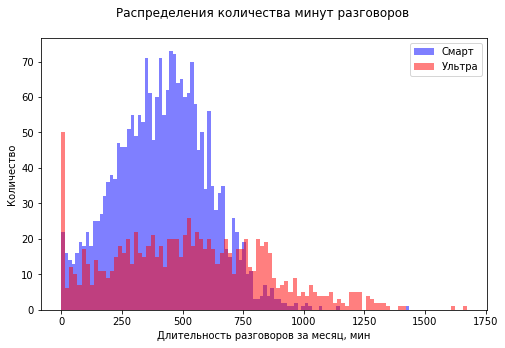

Описание выборки "Смарт" count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: duration, dtype: float64
Описание выборки "Ультра" count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: duration, dtype: float64 

Месяцев, в которые абоненты не говорили по телефону, "Смарт":  8
Месяцев, в которые абоненты не говорили по телефону, "Ультра":  38 

Выборочная дисперсия, "Смарт":  36203.066652094654
Выборочная дисперсия, "Ультра":  100771.22361720211


In [112]:
# Строим диаграмму распределения количества минут разговоров в месяц
df_smart['duration'].plot(kind='hist', bins=100,  figsize=(8, 5), alpha=0.5, label='Смарт', color='blue', 
                          title='Распределения количества минут разговоров \n')
df_ultra['duration'].plot(kind='hist', bins=100, figsize=(8, 5), alpha=0.5, label='Ультра', color='red')
plt.legend()
plt.xlabel('Длительность разговоров за месяц, мин')
plt.ylabel('Количество')
plt.show()

# Выводим информацию о выборках
print('Описание выборки "Смарт"', df_smart['duration'].describe())
print('Описание выборки "Ультра"', df_ultra['duration'].describe(), '\n')

# Находим число месяцев, когда абоненты не говорили по телефону
print('Месяцев, в которые абоненты не говорили по телефону, "Смарт": ', df_smart[df_smart['duration']==0]['duration'].count())
print('Месяцев, в которые абоненты не говорили по телефону, "Ультра": ', df_ultra[df_ultra['duration']==0]['duration'].count(), '\n')

# Находим дисперсию
print('Выборочная дисперсия, "Смарт": ', np.var(df_smart['duration']))
print('Выборочная дисперсия, "Ультра": ', np.var(df_ultra['duration']))

На диаграмме видим два на вид приблизительно нормальных распределения (явное отклонение от нормальности - пики в районе 0 мин). У тарифа "Смарт" медиана и среднее находятся в районе 420 минут, стандартное отклонение 190 минут. У тарифа "Ультра" среднее и медиана в районе 520 минут, разброс заметно больше, чем у "Смарта" - стандартное отклонение 317 минут. Большая часть графика "Ультры" накладывается на график "Смарта".

#### Сообщения

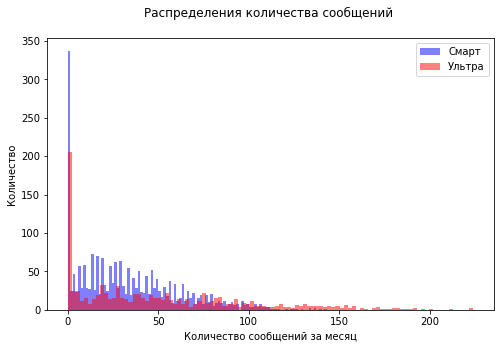

Описание выборки "Смарт" count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_number, dtype: float64
Описание выборки "Ультра" count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages_number, dtype: float64 

Месяцев, в которые абоненты не отправили ни отдного смс, "Смарт":  307
Месяцев, в которые абоненты не отправили ни отдного смс, "Ультра":  190 

Выборочная дисперсия, "Смарт":  796.455482917076
Выборочная дисперсия, "Ультра":  2282.946075394891


In [113]:
# Строим диаграмму распределения количества сообщений в месяц
df_smart['messages_number'].plot(kind='hist', bins=100, figsize=(8, 5), alpha=0.5, label='Смарт', color='blue')
df_ultra['messages_number'].plot(kind='hist', bins=100, figsize=(8, 5), alpha=0.5, label='Ультра', color='red',
                                 title='Распределения количества сообщений \n')
plt.legend()
plt.xlabel('Количество сообщений за месяц')
plt.ylabel('Количество')
plt.show()

# Выводим информацию о выборках
print('Описание выборки "Смарт"', df_smart['messages_number'].describe())
print('Описание выборки "Ультра"', df_ultra['messages_number'].describe(), '\n')

# Находим число месяцев, когда абоненты не отправляли смс
print('Месяцев, в которые абоненты не отправили ни отдного смс, "Смарт": ', df_smart[df_smart['messages_number']==0]['messages_number'].count())
print('Месяцев, в которые абоненты не отправили ни отдного смс, "Ультра": ', df_ultra[df_ultra['messages_number']==0]['messages_number'].count(), '\n')

# Находим дисперсию
print('Выборочная дисперсия, "Смарт": ', np.var(df_smart['messages_number']))
print('Выборочная дисперсия, "Ультра": ', np.var(df_ultra['messages_number']))

Видим два распределения с большим разбросом. У тарифа "Смарт" медиана и среднее находятся в районе 30 смс, стандартное отклонение 28 минут. У тарифа "Ультра" среднее - 49 смс, медиана - 38 смс, разброс заметно больше из-за скошенности вправо, стандартное отклонение 47 смс. Снова большая часть графика "Ультры" накладывается на график "Смарта".

#### Интернет-трафик

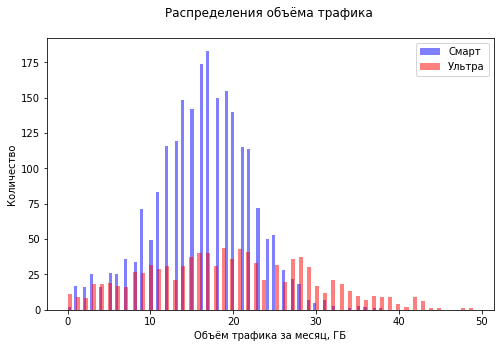

Описание выборки "Смарт" count    2229.000000
mean       16.328847
std         5.747061
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64
Описание выборки "Ультра" count    985.000000
mean      19.494416
std        9.853511
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64 

Месяцев, в которые абоненты не использовали ни одного гигабайта, "Смарт":  2
Месяцев, в которые абоненты не использовали ни одного гигабайта, "Ультра":  11 

Выборочная дисперсия, "Смарт":  33.01388745483741
Выборочная дисперсия, "Ультра":  96.99311602978705


In [114]:
# Строим диаграмму распределения объёма трафика в месяц
df_smart['gb_used'].plot(kind='hist', bins=100, figsize=(8, 5), alpha=0.5, label='Смарт', color='blue',
                         title='Распределения объёма трафика \n')
df_ultra['gb_used'].plot(kind='hist', bins=100, figsize=(8, 5), alpha=0.5, label='Ультра', color='red')
plt.xlabel('Объём трафика за месяц, ГБ')
plt.ylabel('Количество')
plt.legend()
plt.show()

# Выводим информацию о выборке
print('Описание выборки "Смарт"', df_smart['gb_used'].describe())
print('Описание выборки "Ультра"', df_ultra['gb_used'].describe(), '\n')

# Находим число месяцев, когда абоненты не использовали ни одного гигабайта
print('Месяцев, в которые абоненты не использовали ни одного гигабайта, "Смарт": ', df_smart[df_smart['gb_used']==0]['gb_used'].count())
print('Месяцев, в которые абоненты не использовали ни одного гигабайта, "Ультра": ', df_ultra[df_ultra['gb_used']==0]['gb_used'].count(), '\n')

# Находим дисперсию
print('Выборочная дисперсия, "Смарт": ', np.var(df_smart['gb_used']))
print('Выборочная дисперсия, "Ультра": ', np.var(df_ultra['gb_used']))

Здесь два почти симметричных нормальных распределения. Среднее и медиана "Смарта" в районе 17 ГБ, среднее и медиана "Ультры" в районе 19 ГБ. У "Смарта" более чёткий пик, стандартное отклонение - почти 6 ГБ, у "Ультры" - почти 10 ГБ. Как и раньше, большая часть графика "Ультры" накладывается на график "Смарта".

#### Расходы на связь

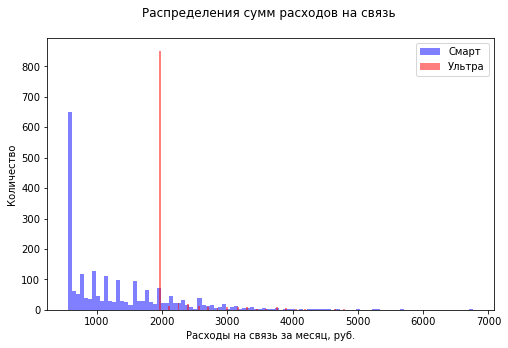

Описание выборки "Смарт" count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: expense, dtype: float64
Описание выборки "Ультра" count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: expense, dtype: float64 

Дисперсия, "Смарт":  669485.2209234155
Дисперсия, "Ультра":  141373.07325620213


In [115]:
# Строим диаграмму распределения расходов на связь в месяц
df_smart['expense'].plot(kind='hist', bins=100, figsize=(8, 5), alpha=0.5, label='Смарт', color='blue',
                         title='Распределения сумм расходов на связь \n')
df_ultra['expense'].plot(kind='hist', bins=100, figsize=(8, 5), alpha=0.5, label='Ультра', color='red')
plt.xlabel('Расходы на связь за месяц, руб.')
plt.ylabel('Количество')
plt.legend()
plt.show()

# Выводим информацию о выборке
print('Описание выборки "Смарт"', df_smart['expense'].describe())
print('Описание выборки "Ультра"', df_ultra['expense'].describe(), '\n')

# Находим дисперсию
print('Дисперсия, "Смарт": ', np.var(df_smart['expense']))
print('Дисперсия, "Ультра": ', np.var(df_ultra['expense']))

Здесь для каждого из тарифов мы видим чёткие пики в районе стоимости каждого тарифного плана - 550 руб. и 1950 руб. Также видим, что для тарифа "Смарт" значительно больше доля тех, кто платит сверх тарифного плана, меньше среднее, но зато разброс почти в два раза больше, чем у "Ультры".

### Анализ динамики выручки и числа абонентов по месяцам

Построим диаграмму зависимости суммарной выручки от месяца для каждого из тарифов.

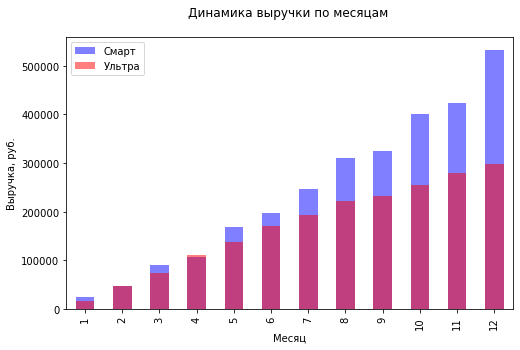

In [116]:
# Строим диграмму зависимости суммарной выручки от месяца для обоих тарифов
df_smart.groupby('month')['expense'].sum().plot.bar(figsize=(8, 5), color='blue', alpha=0.5, label='Смарт')
df_ultra.groupby('month')['expense'].sum().plot.bar(figsize=(8, 5), color='red', alpha=0.5, label='Ультра')
plt.title('Динамика выручки по месяцам \n')
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Выручка, руб.')
plt.show()

На диаграмме видно, что с 5 месяца "Смарт" стабильно обгоняет "Ультру" по выручке и в целом растёт более стремительно. 

Можно попробовать объяснить лидирование "Смарта" более резким увеличением числа абонентов со временем. Посмотрим на динамику числа абонентов: 

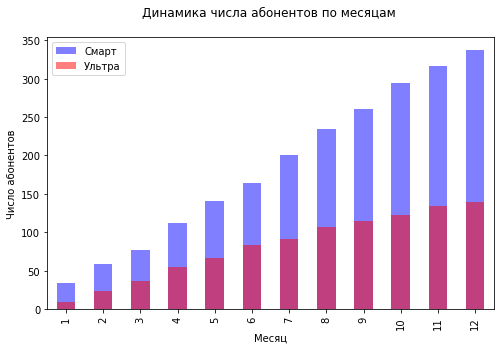

In [117]:
# Строим диграмму зависимости числа абонентов от месяца для обоих тарифов
df_smart.groupby('month')['user_id'].count().plot.bar(figsize=(8, 5), color='blue', alpha=0.5, label='Смарт')
df_ultra.groupby('month')['user_id'].count().plot.bar(figsize=(8, 5), color='red', alpha=0.5, label='Ультра')
plt.title('Динамика числа абонентов по месяцам \n')
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Число абонентов')
plt.show()

Действительно, люди заметно охотнее подключат тариф "Смарт". Интересно, как обстоит дело со средним значением выручки по абонентам в месяц:

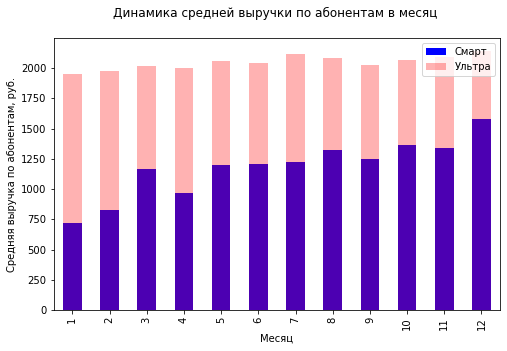

In [118]:
# Строим диграмму средней выручки по абонентам для обоих тарифов
df_smart.groupby('month')['expense'].mean().plot.bar(figsize=(8, 5), color='blue', alpha=1, label='Смарт')
df_ultra.groupby('month')['expense'].mean().plot.bar(figsize=(8, 5), color='red', alpha=0.3, label='Ультра')
plt.title('Динамика средней выручки по абонентам в месяц \n')
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Средняя выручка по абонентам, руб.')
plt.show()

Средняя выручка "Ультры" на всём отрезке больше, чем у "Смарта", однако в первом случае мы видим весьма незначительные колебания в районе 2000 рублей, а во втором случае плавный рост с увеличением среднего в 2 раза за 12 месяцев - примерно от 750 до 1500 рублей.

### Проверка статистических гипотез

Сначала предстоит исследовать равенство выручки пользователей двух тарифов.

Нулевая гипотеза: средние выручки пользователей тарифов «Ультра» и «Смарт» равны.

Альтернативная гипотеза: средние выручки пользователей тарифов «Ультра» и «Смарт» не равны.

In [119]:
# находим дисперсию обеих выборок
display(np.var(df_ultra['expense']))
display(np.var(df_smart['expense']))
# проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
alpha = .05
results = st.ttest_ind(df_ultra['expense'], df_smart['expense'], equal_var = False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

141373.07325620213

669485.2209234155

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


Исходя из результатов статистической проверки, можем утверждать, что средние двух генеральных совокупностей отличаются. Найдём средние двух выборок:

In [120]:
print('Пользователи тарифа "Ультра" в месяц в среднем тратят', df_ultra['expense'].mean())
print('Пользователи тарифа "Смарт" в месяц в среднем тратят', df_smart['expense'].mean())

Пользователи тарифа "Ультра" в месяц в среднем тратят 2070.1522842639592
Пользователи тарифа "Смарт" в месяц в среднем тратят 1289.9735307312696


Теперь исследуем равенство выручки пользователей из Москвы и из других городов. Но сначала соберём соответствующие датасеты.

Нулевая гипотеза: средние выручки пользователей из Москвы и из других городов равны.

Альтернативная гипотеза: выручки пользователей из Москвы и из других городов не равны.

In [121]:
# создаём датасеты
moscow_users = df_ultra[df_ultra['city']=='Москва']['expense'].tolist() + df_smart[df_smart['city']=='Москва']['expense'].tolist()
other_users = df_ultra[df_ultra['city']!='Москва']['expense'].tolist() + df_smart[df_smart['city']!='Москва']['expense'].tolist()

In [122]:
# находим дисперсию обеих выборок
display(np.var(pd.Series(moscow_users)))
display(np.var(pd.Series(other_users)))
# проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
alpha = .05
results = st.ttest_ind(moscow_users, other_users)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

564710.7117467293

653886.3270894091

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Найдём среднее двух выборок:

In [123]:
# создаём функцию, которая будет считать среднее значения из списка
def avrg(lst):
    return sum(lst) / len(lst)

# выводим средние значения
print('Польватели из Москвы в месяц в среднем тратят', avrg(moscow_users))
print('Польватели из остальных городов в месяц в среднем тратят', avrg(other_users))

Польватели из Москвы в месяц в среднем тратят 1546.7135842880523
Польватели из остальных городов в месяц в среднем тратят 1524.9362274298885


Действительно, получили довольно близкие значения.

Нулевая гипотеза должна содержать знак равенства, поэтому в обоих случаях она была сформулирована как утверждение о равенстве средних двух генеральных совокупностей. Альтернативная гипотеза должна противоречить нулевой, поэтому в обоих случаях она была сформулирована как утверждение о неравенстве.

Для проверки гипотез использовали t-критерий Стьюдента, т.к. именно его принято использовать для проверки такого рода гипотез. Параметр equal_var принимал значение True, если предварительно найденные дисперсии были близки, False - если сильно отличались. 

## Выводы:
 - в плане расхода минут, смс и гигабайтов поведение абонентов тарифа "Смарт" отличается меньшим средним и меньшим разбросом по сравнению с поведением абонентов "Ультры";
 - выручка от абонентов "Смарта", наоборот, отличатся большим разбросом, тогда как большенство абонентов "Ультры" платит только абонентскую плату;
 - с одной стороны, средняя месячная выручка в пределах 2018 года у абонентов "Ультры" выше, чем у абонентов "Смарта" - 2070 и 1290 рублей соответственно;
 - с другой стороны, динамика по месяцам показывает, что суммарная месячная выручка от "Смарта" в мае обогнала выручку от "Ультры" и с тех пор растёт более стремительными темпами. Этот рост объясняется как более резким ростом числа абонентов "Смарта", так и плавным ростом средней по абонентам выручки за каждый месяц, тогда как средняя выручка абонентов "Ультры" меняется очень слабо. Следовательно, именно тариф "Смарт" стоит продвигать, т.к. он приносит больше денег и показывает лучшую динамику;
 - в среднем абоненты из Москвы тратят на связь примерно столько же, сколько абоненты из других городов - порядка 1500 рублей.